<a href="https://colab.research.google.com/github/Nta1510/BTL-TTCS/blob/main/D%E1%BB%B1_%C4%91o%C3%A1n_tu%E1%BB%95i_v%C3%A0_gi%E1%BB%9Bi_t%C3%ADnh_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Cài đặt thư viện cần thiết và chuẩn bị API Kaggle
!pip install -q kaggle
!pip install -q gradio seaborn

from google.colab import files
print("Upload file kaggle.json")
files.upload()  # Tải lên file kaggle.json từ máy

# 2. Thiết lập cấu hình để sử dụng Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Tải dataset UTKFace từ Kaggle và giải nén
!kaggle datasets download -d jangedoo/utkface-new
!unzip -oq utkface-new.zip -d utkface

Upload file kaggle.json


Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install -q gradio seaborn


# 4. Import các thư viện Python cần thiết
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error
import seaborn as sns
import gradio as gr

In [ ]:
# 5. Đọc danh sách ảnh và trích xuất nhãn tuổi và giới tính từ tên file
dir_path = "utkface/UTKFace/"
image_paths = [f for f in os.listdir(dir_path) if f.endswith(".jpg")]
np.random.shuffle(image_paths)

ages = []
genders = []
for p in image_paths:
    parts = p.split("_")
    ages.append(int(parts[0]))
    genders.append(int(parts[1]))  # 0: nam, 1: nữ

print(f"Tổng số ảnh: {len(image_paths)}")

Tổng số ảnh: 23708


In [ ]:
# 6. Chia dữ liệu thành tập train, validation, test
train_images, test_images, train_ages, test_ages, train_genders, test_genders = train_test_split(
    image_paths, ages, genders, train_size=0.9, random_state=42)

train_images, valid_images, train_ages, valid_ages, train_genders, valid_genders = train_test_split(
    train_images, train_ages, train_genders, train_size=0.9, random_state=42)

print(f"Train: {len(train_images)}, Valid: {len(valid_images)}, Test: {len(test_images)}")

Train: 19203, Valid: 2134, Test: 2371


In [ ]:
# 7. Tiền xử lý ảnh và nhãn (resize, chuẩn hóa, convert float32)
IMAGE_SIZE = 160
BATCH_SIZE = 32

def preprocess_data(image_path, age, gender):
    full_path = tf.strings.join([dir_path, image_path])
    image = tf.io.read_file(full_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, (tf.cast(age, tf.float32), tf.cast(gender, tf.float32))

In [ ]:
# 8. Tạo dataset TensorFlow cho train, validation, test
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_ages, train_genders))
train_ds = train_ds.map(preprocess_data).shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders))
valid_ds = valid_ds.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_ages, test_genders))
test_ds = test_ds.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
# 9. Xây dựng mô hình dùng MobileNetV2 với 2 đầu ra: tuổi và giới tính
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

# Nhánh dự đoán tuổi
age_branch = Dense(128, activation='relu')(x)
age_output = Dense(1, name='age')(age_branch)

# Nhánh dự đoán giới tính
gender_branch = Dense(128, activation='relu')(x)
gender_output = Dense(1, activation='sigmoid', name='gender')(gender_branch)

model = Model(inputs=inputs, outputs=[age_output, gender_output])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 10. Compile mô hình
model.compile(optimizer='adam',
              loss={'age': 'mae', 'gender': 'binary_crossentropy'},
              metrics={'age': 'mae', 'gender': 'accuracy'})
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 5, 5,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    163,968 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        129 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,586,178 (9.87 MB)

 Trainable params: 328,194 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 11. Huấn luyện mô hình
history = model.fit(train_ds, validation_data=valid_ds, epochs=10)


Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 469s 766ms/step - age_loss: 12.3688 - age_mae: 12.3688 - gender_accuracy: 0.7528 - gender_loss: 0.5158 - loss: 12.8846 - val_age_loss: 9.1972 - val_age_mae: 9.1988 - val_gender_accuracy: 0.8290 - val_gender_loss: 0.3816 - val_loss: 9.5805
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 419s 696ms/step - age_loss: 9.7595 - age_mae: 9.7595 - gender_accuracy: 0.8040 - gender_loss: 0.4140 - loss: 10.1735 - val_age_loss: 8.6741 - val_age_mae: 8.6766 - val_gender_accuracy: 0.8402 - val_gender_loss: 0.3604 - val_loss: 9.0369
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 423s 703ms/step - age_loss: 9.4357 - age_mae: 9.4358 - gender_accuracy: 0.8219 - gender_loss: 0.3888 - loss: 9.8245 - val_age_loss: 8.6655 - val_age_mae: 8.6668 - val_gender_accuracy: 0.8486 - val_gender_loss: 0.3494 - val_loss: 9.0163
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 466s 773ms/step - age_loss: 9.2770 - age_mae: 9.2770 - gender_accuracy: 0.8295 - gender_loss: 0.3739 - loss: 9.6509 - val_age_lo

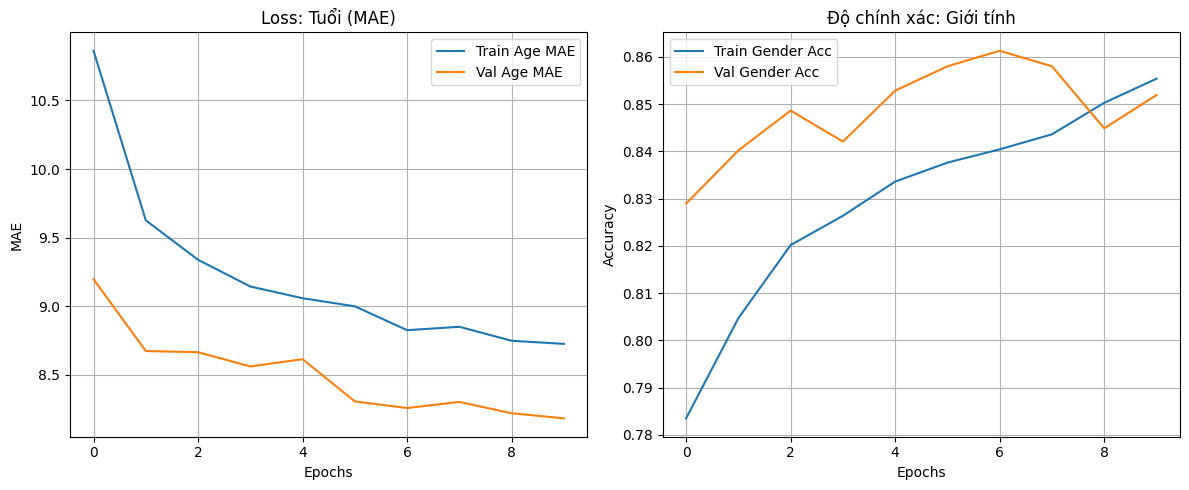

In [ ]:
# 12. Biểu đồ Loss & Accuracy
hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_df['age_loss'], label='Train Age MAE')
plt.plot(hist_df['val_age_loss'], label='Val Age MAE')
plt.title("Loss: Tuổi (MAE)")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['gender_accuracy'], label='Train Gender Acc')
plt.plot(hist_df['val_gender_accuracy'], label='Val Gender Acc')
plt.title("Độ chính xác: Giới tính")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


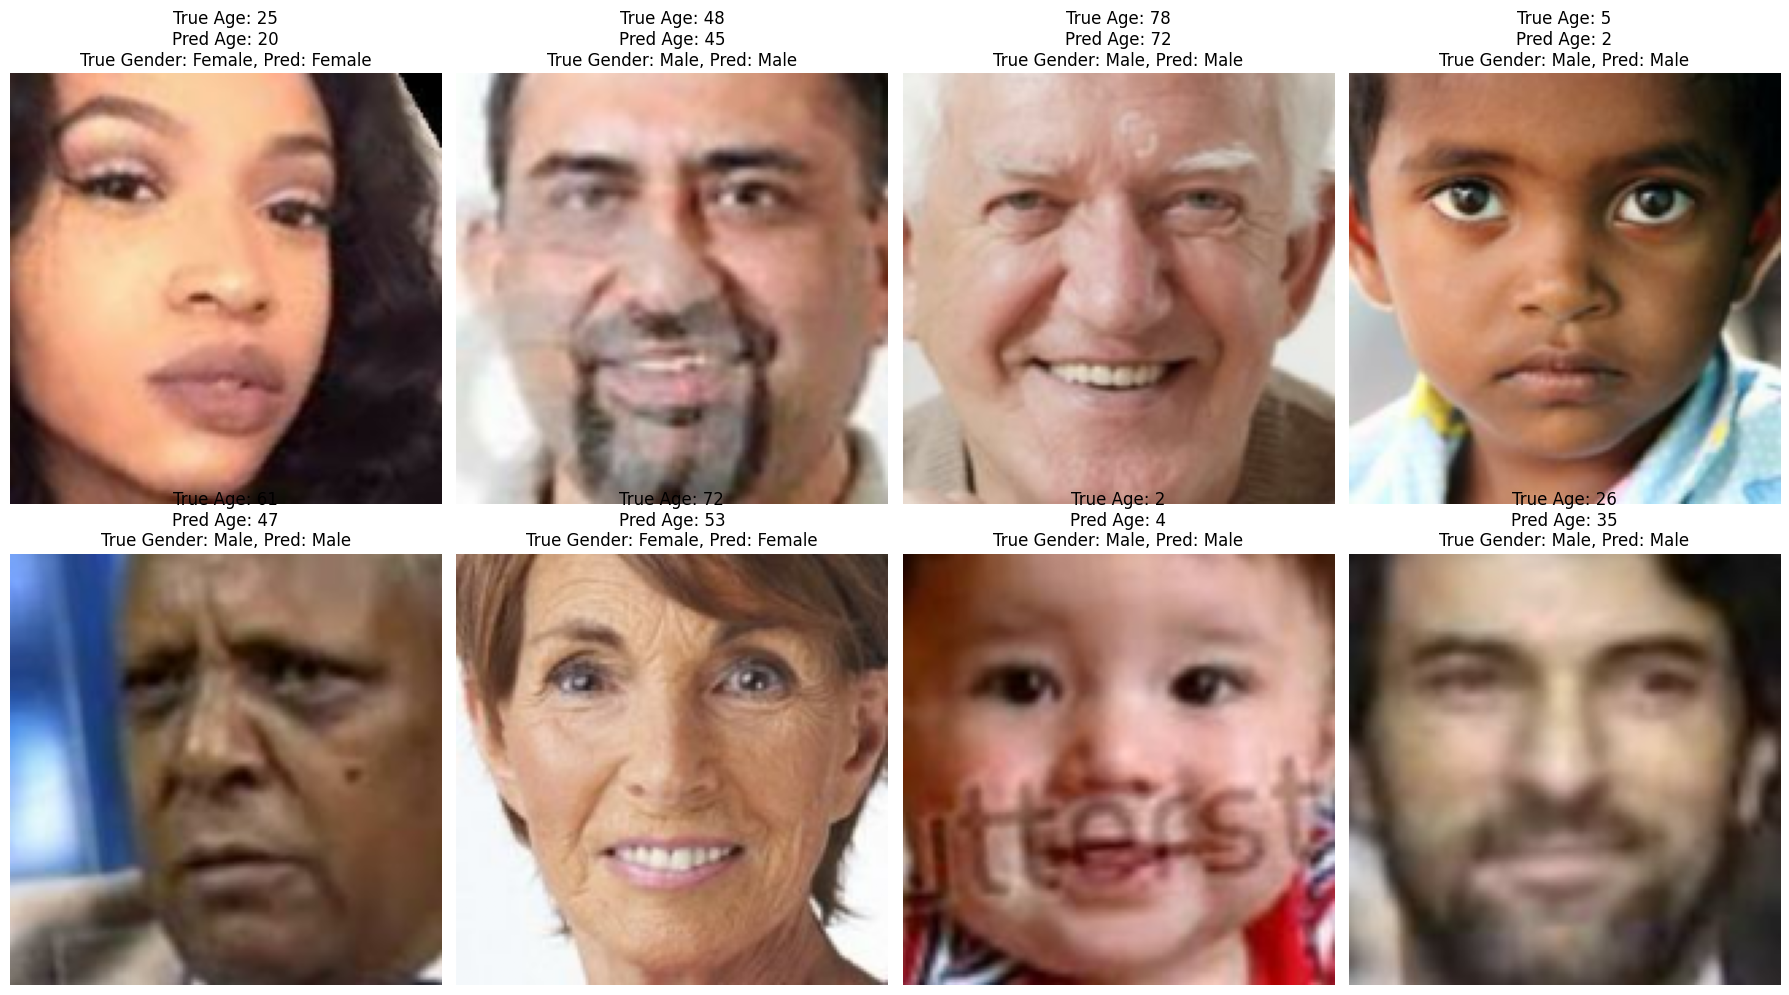

In [ ]:
# 13. Dự đoán và hiển thị kết quả trên tập test
for images, (true_ages, true_genders) in test_ds.take(1):
    pred_ages, pred_genders = model.predict(images)

    plt.figure(figsize=(18, 10))
    for i in range(min(len(images), 8)):
        gender_label = "Male" if int(true_genders[i]) == 0 else "Female"
        pred_gender_label = "Male" if pred_genders[i][0] < 0.5 else "Female"
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"True Age: {int(true_ages[i])}\nPred Age: {int(pred_ages[i][0])}\n"
                  f"True Gender: {gender_label}, Pred: {pred_gender_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

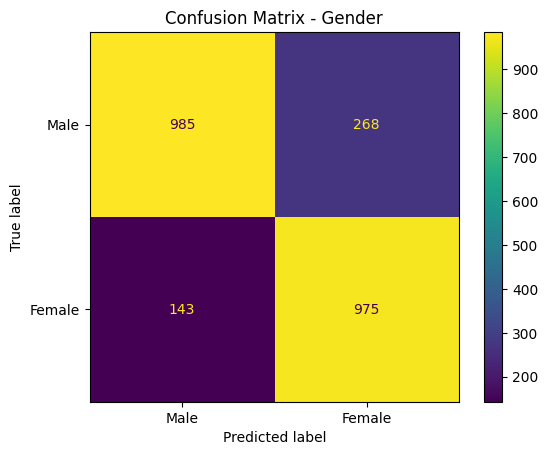

In [ ]:
# 14. Confusion Matrix cho giới tính
true_genders_all = []
pred_genders_all = []
for images, (_, true_genders) in test_ds:
    _, preds = model.predict(images)
    true_genders_all.extend(true_genders.numpy())
    pred_genders_all.extend((preds > 0.5).astype(int).flatten())

cm = confusion_matrix(true_genders_all, pred_genders_all)
ConfusionMatrixDisplay(cm, display_labels=["Male", "Female"]).plot()
plt.title("Confusion Matrix - Gender")
plt.grid(False)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

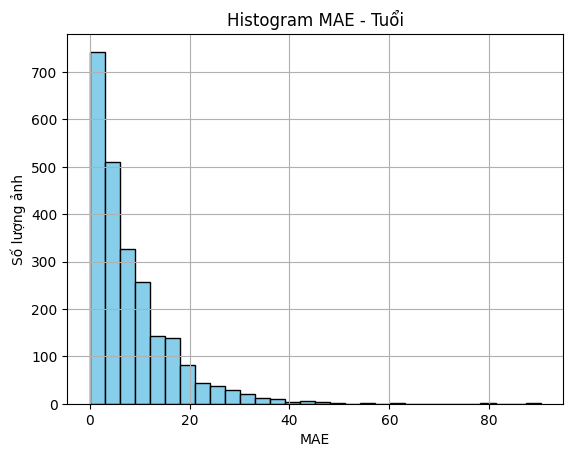

In [ ]:
# 15. Histogram MAE của tuổi trên tập test
true_ages_all = []
pred_ages_all = []
for images, (true_ages, _) in test_ds:
    pred_ages, _ = model.predict(images)
    true_ages_all.extend(true_ages.numpy())
    pred_ages_all.extend(pred_ages.flatten())

mae_values = np.abs(np.array(true_ages_all) - np.array(pred_ages_all))
plt.hist(mae_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram MAE - Tuổi")
plt.xlabel("MAE")
plt.ylabel("Số lượng ảnh")
plt.grid(True)
plt.show()

In [ ]:
# 16. Triển khai giao diện Gradio

def predict_age_gender(image):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis=0)
    age_pred, gender_pred = model.predict(image)
    gender_label = "Male" if gender_pred[0][0] < 0.5 else "Female"
    return f"Dự đoán tuổi: {int(age_pred[0][0])}, Giới tính: {gender_label}"

demo = gr.Interface(fn=predict_age_gender,
                    inputs=gr.Image(type="numpy"),
                    outputs="text",
                    title="Dự đoán Tuổi & Giới tính từ Ảnh")

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://45aed9273baf86f429.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
